In [1]:
import os
from pathlib import Path
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from fastai.tabular.all import *
import seaborn as sb

This notebook takes the raw/downloaded information and pre-process it into a format suitable for AI/ML approaches. This pre-processing procedure assumes all gridded data is in the same spatio-temporal resolution.

# Outcome variable (or predictand)

The outcome variable is fuel load per unit area = CC * AGB * BA / CellArea

## Area (Km^2)

In [2]:
"""Load area data into an xarray dataset"""
area_data = xr.open_mfdataset("/data1/downloaded/area.nc")
area_data = area_data.layer
area_data

<xarray.DataArray 'layer' (latitude: 720, longitude: 1440)>
dask.array<open_dataset-a7922b70e8d438b1436e0b7fe35859adlayer, shape=(720, 1440), dtype=float32, chunksize=(720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float64 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * latitude   (latitude) float64 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
Attributes:
    grid_mapping:  crs
    proj4:         +proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0
    min:           1.6840330020145782
    max:           769.3152353963371

## Combustion completeness (CC)

In [3]:
"""Load CC data into an xarray dataset"""
cc_data = xr.open_dataset("/data1/downloaded/GFED4_basis_regions_cc_all.nc")
cc_data = cc_data.layer
cc_data

<xarray.DataArray 'layer' (latitude: 720, longitude: 1440)>
[1036800 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float64 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * latitude   (latitude) float64 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
Attributes:
    grid_mapping:  crs
    proj4:         +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=...
    min:           0.48
    max:           0.94

## Above Ground Biomass (AGB)

In [4]:
"""Load AGB data into an xarray dataset"""
agb_data = xr.open_dataset("/data1/raw_data/veg_2010_2016/all_veg_data.nc")
agb_data

<xarray.Dataset>
Dimensions:                (latitude: 720, longitude: 1440, time: 84)
Coordinates:
  * time                   (time) datetime64[ns] 2010-01-01 ... 2016-12-01
  * longitude              (longitude) float32 -179.9 -179.6 ... 179.6 179.9
  * latitude               (latitude) float32 -89.88 -89.62 ... 89.62 89.88
Data variables:
    abg_avitabile_vod5th   (time, latitude, longitude) float64 ...
    abg_avitabile_vodmean  (time, latitude, longitude) float64 ...
    abg_avitabile_vod95th  (time, latitude, longitude) float64 ...
    abg_baccini_vod5th     (time, latitude, longitude) float64 ...
    abg_baccini_vodmean    (time, latitude, longitude) float64 ...
    abg_baccini_vod95th    (time, latitude, longitude) float64 ...
    abg_saatchi_vod5th     (time, latitude, longitude) float64 ...
    abg_saatchi_vodmean    (time, latitude, longitude) float64 ...
    abg_saatchi_vod95th    (time, latitude, longitude) float64 ...

Now select below which data variable you would like to use as outcome, this will be used to mask all the other features.

In [5]:
# We suggest to select one of the maps by Avitabile et al.
# This is the outcome variable and also works as mask for all the features.
# All the features geerated from here onwards, will depend on this choice!
vartype = "mean"  # it can also be '05th' or '95th'
varname = "abg_avitabile_vod" + vartype

agb_data = eval("agb_data." + varname)
# Units
agb_data.units

'Mg/h'

In [6]:
agb_data

<xarray.DataArray 'abg_avitabile_vodmean' (time: 84, latitude: 720, longitude: 1440)>
[87091200 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2016-12-01
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
Attributes:
    long_name:  AGB estimation using a relation Avitabile et al. as a fct of ...
    units:      Mg/h

Please note the units of AGB are Mg/h!

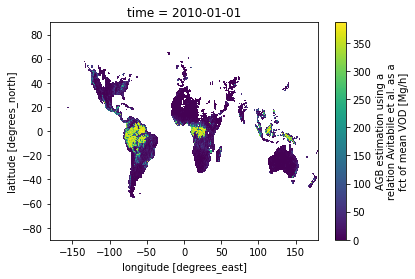

In [7]:
agb_data[0].plot()

In [8]:
# One of the predictors (VOD) is available from April 2010 to December 2016.
# Therefore here we remove Jan-Feb-Mar 2016.
agb_data = agb_data.loc["2010-04-01":"2016-12-31"]

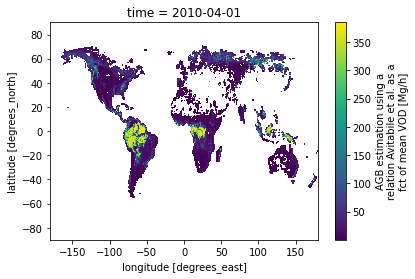

In [9]:
# Mask out where AGB is zero
AGB_THRESH = 0

agb_data = agb_data.where(agb_data != AGB_THRESH)
agb_data[0].plot()

## Burned Area (BA)

In [10]:
"""Load BA data into an xarray dataset"""
ba_data = xr.open_mfdataset(
    "/data1/raw_data/burned_area_2010_2018/201[0-6]*-ESACCI-L4_FIRE-BA-MODIS-fv5.1.nc"
)
# Units
ba_data.burned_area.units

'm2'

Please note the units of BA are m2!

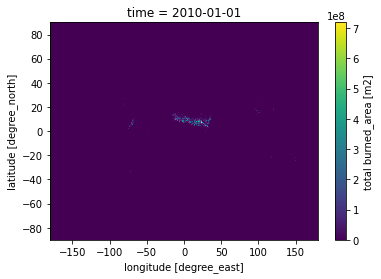

In [11]:
# Rename lat/lon dimensions
ba_data = ba_data.rename({"lon": "longitude", "lat": "latitude"})
# Extract only burned areas
ba_data = ba_data.burned_area

ba_data[0].plot()

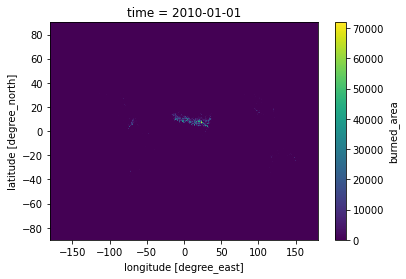

In [12]:
# Convert m2 to hectares
ba_data_h = ba_data * 0.0001
ba_data_h[0].plot()

In [13]:
# One of the predictors (VOD) is available from April 2010 to December 2016.
# Therefore here we remove Jan-Feb-Mar 2016.
ba_data_h = ba_data_h.loc["2010-04-01":"2016-12-31"]

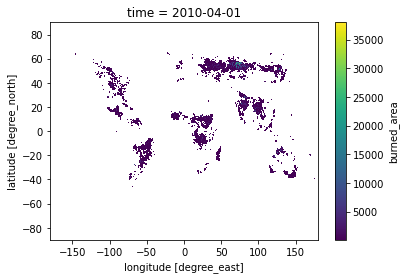

In [14]:
# Mask out low values (small fires)
BA_THRESH = 50  # hectares
ba_data_h = ba_data_h.where(ba_data_h > BA_THRESH)

ba_data_h[0].plot()

## Dry Matter (DM)

The fuel load or dry matter (Mg/Km2) is the Above Ground Biomass (Mg/h) * Burned Area (h) * Combustion Completeness (this is unitless rate) / the area of each cell (Km2). This operation is straightforward because the grids have the same spatial and temporal resolution! Please note the result shows values where BA, CC and AGB are not equal to NA. 

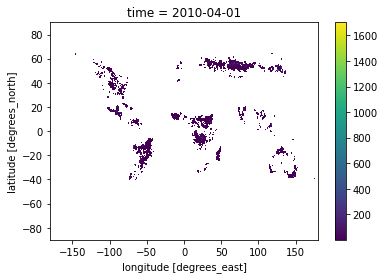

In [15]:
load_data = agb_data * ba_data_h * cc_data / area_data
load_data[0].plot()

In [ ]:
# Store data, if needed.
folder_path = "/home/moc0/ai-vegetation-fuel/data/inputs/nc_files_" + vartype + "/"
Path(folder_path).mkdir(parents=True, exist_ok=True)
load_data.to_netcdf(folder_path + "load_Mg_over_Km2_2010-2016.nc")

In [16]:
load_data

<xarray.DataArray (time: 81, latitude: 720, longitude: 1440)>
dask.array<truediv, shape=(81, 720, 1440), dtype=float64, chunksize=(1, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * time       (time) datetime64[ns] 2010-04-01 2010-05-01 ... 2016-12-01
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9

In [17]:
# Convert cells with non missing values to dataframe
df = load_data.to_dataframe(name="fuel_load").dropna().reset_index()
df

,time,latitude,longitude,fuel_load
0,2010-04-01,-39.875,-65.375,0.235708
1,2010-04-01,-39.625,-73.125,5.152665
2,2010-04-01,-39.375,175.125,15.806868
3,2010-04-01,-39.125,-72.375,7.532907
4,2010-04-01,-39.125,-72.125,21.445339
...,...,...,...,...
720462,2016-12-01,45.125,2.875,3.711282
720463,2016-12-01,48.125,-120.125,9.861333
720464,2016-12-01,49.125,-0.375,2.790013
720465,2016-12-01,49.125,-0.125,1.610908


In [18]:
# Example: retrieve data at the grid cells nearest to the target latitudes, longitudes and time
# y = x["index"].sel(longitude=target_lon, latitude=target_lat, time=target_t, method="nearest")
# Where
target_lon = xr.DataArray(df['longitude'], dims="points")
target_lat = xr.DataArray(df['latitude'], dims="points")
target_t = xr.DataArray(df['time'], dims="points")

# Static predictors

## Climatic regions (categorical)

In [19]:
"""Load climatic regions data into an xarray dataset"""
cr_data = xr.open_dataset("/data1/raw_data/Beck_KG_V1_present_0p0083.gridName0320.nc")

# Rotate longitude coordinates
cr_data = cr_data.assign_coords(
    longitude=(((cr_data.longitude + 180) % 360) - 180)
).sortby("longitude")

cr_data

<xarray.Dataset>
Dimensions:          (latitude: 601, longitude: 1200)
Coordinates:
  * latitude         (latitude) float64 90.0 89.7 89.4 ... -89.4 -89.7 -90.0
  * longitude        (longitude) float64 -180.0 -179.7 -179.4 ... 179.4 179.7
Data variables:
    climatic_region  (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2020-12-20T06:06:38 GRIB to CDM+CF via cfgrib-0....

In [20]:
# Retrieve data at the grid cells nearest to the target latitudes and longitudes
df["climatic_region"] = cr_data["climatic_region"].sel(longitude=target_lon,
                                                       latitude=target_lat,
                                                       method="nearest")
df

,time,latitude,longitude,fuel_load,climatic_region
0,2010-04-01,-39.875,-65.375,0.235708,1.000000
1,2010-04-01,-39.625,-73.125,5.152665,NaN
2,2010-04-01,-39.375,175.125,15.806868,3.000000
3,2010-04-01,-39.125,-72.375,7.532907,3.000000
4,2010-04-01,-39.125,-72.125,21.445339,3.000000
...,...,...,...,...,...
720462,2016-12-01,45.125,2.875,3.711282,2.406028
720463,2016-12-01,48.125,-120.125,9.861333,1.018566
720464,2016-12-01,49.125,-0.375,2.790013,NaN
720465,2016-12-01,49.125,-0.125,1.610908,NaN


The climatic regions are 5 categories (1 to 5), the floating number make me think they might have been previously pre-processed in the wrong way. Let's fix this by rounding to the nearest integer and then converting to a categorical type.

In [21]:
df["climatic_region"] = df["climatic_region"].round().astype('category')
df

,time,latitude,longitude,fuel_load,climatic_region
0,2010-04-01,-39.875,-65.375,0.235708,1.0
1,2010-04-01,-39.625,-73.125,5.152665,NaN
2,2010-04-01,-39.375,175.125,15.806868,3.0
3,2010-04-01,-39.125,-72.375,7.532907,3.0
4,2010-04-01,-39.125,-72.125,21.445339,3.0
...,...,...,...,...,...
720462,2016-12-01,45.125,2.875,3.711282,2.0
720463,2016-12-01,48.125,-120.125,9.861333,1.0
720464,2016-12-01,49.125,-0.375,2.790013,NaN
720465,2016-12-01,49.125,-0.125,1.610908,NaN


## Biomes (categorical)

In [22]:
"""Load slope data into an xarray dataset"""
biomes = xr.open_dataset("/data1/downloaded/landcover_25.nc")
# Convert to data array and select the only time step available
biomes = biomes.STRF[0]
biomes

<xarray.DataArray 'STRF' (latitude: 720, longitude: 1440)>
[1036800 values with dtype=float64]
Coordinates:
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
    time       datetime64[ns] 2000-01-01
Attributes:
    long_name:  Stream function
    units:      m**2 s**-1
    code:       1
    table:      255

In [23]:
# Retrieve data at the grid cells nearest to the target latitudes and longitudes
df["biome"] = biomes.sel(longitude=target_lon,
                         latitude=target_lat,
                         method="nearest")
df

,time,latitude,longitude,fuel_load,climatic_region,biome
0,2010-04-01,-39.875,-65.375,0.235708,1.0,1.0
1,2010-04-01,-39.625,-73.125,5.152665,NaN,7.0
2,2010-04-01,-39.375,175.125,15.806868,3.0,7.0
3,2010-04-01,-39.125,-72.375,7.532907,3.0,1.0
4,2010-04-01,-39.125,-72.125,21.445339,3.0,1.0
...,...,...,...,...,...,...
720462,2016-12-01,45.125,2.875,3.711282,2.0,1.0
720463,2016-12-01,48.125,-120.125,9.861333,1.0,7.0
720464,2016-12-01,49.125,-0.375,2.790013,NaN,1.0
720465,2016-12-01,49.125,-0.125,1.610908,NaN,1.0


Biomes are also categorical and there datatype must be fixed.

In [24]:
df["biome"] = df["biome"].astype('category')
df

,time,latitude,longitude,fuel_load,climatic_region,biome
0,2010-04-01,-39.875,-65.375,0.235708,1.0,1.0
1,2010-04-01,-39.625,-73.125,5.152665,NaN,7.0
2,2010-04-01,-39.375,175.125,15.806868,3.0,7.0
3,2010-04-01,-39.125,-72.375,7.532907,3.0,1.0
4,2010-04-01,-39.125,-72.125,21.445339,3.0,1.0
...,...,...,...,...,...,...
720462,2016-12-01,45.125,2.875,3.711282,2.0,1.0
720463,2016-12-01,48.125,-120.125,9.861333,1.0,7.0
720464,2016-12-01,49.125,-0.375,2.790013,NaN,1.0
720465,2016-12-01,49.125,-0.125,1.610908,NaN,1.0


## GFED basis region

In [25]:
"""Load GFED basis region into an xarray dataset"""
gfedregions_data = xr.open_mfdataset("/data1/downloaded/GFED4_basis_regions_id.nc")

gfedregions_data

<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440)
Coordinates:
  * longitude  (longitude) float64 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * latitude   (latitude) float64 89.88 89.62 89.38 ... -89.38 -89.62 -89.88
Data variables:
    crs        int32 ...
    layer      (latitude, longitude) float32 dask.array<chunksize=(720, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.4
    created_by:   R, packages ncdf4 and raster (version 3.4-5)
    date:         2021-05-04 09:48:39

In [26]:
# Retrieve data at the grid cells nearest to the target latitudes and longitudes
df["GFEDregions"] = gfedregions_data.layer.sel(longitude=target_lon,
                                               latitude=target_lat,
                                               method="nearest")
df

,time,latitude,longitude,fuel_load,climatic_region,biome,GFEDregions
0,2010-04-01,-39.875,-65.375,0.235708,1.0,1.0,5.0
1,2010-04-01,-39.625,-73.125,5.152665,NaN,7.0,5.0
2,2010-04-01,-39.375,175.125,15.806868,3.0,7.0,14.0
3,2010-04-01,-39.125,-72.375,7.532907,3.0,1.0,5.0
4,2010-04-01,-39.125,-72.125,21.445339,3.0,1.0,5.0
...,...,...,...,...,...,...,...
720462,2016-12-01,45.125,2.875,3.711282,2.0,1.0,6.0
720463,2016-12-01,48.125,-120.125,9.861333,1.0,7.0,2.0
720464,2016-12-01,49.125,-0.375,2.790013,NaN,1.0,6.0
720465,2016-12-01,49.125,-0.125,1.610908,NaN,1.0,6.0


In [27]:
df["GFEDregions"] = df["GFEDregions"].astype('category')
df

,time,latitude,longitude,fuel_load,climatic_region,biome,GFEDregions
0,2010-04-01,-39.875,-65.375,0.235708,1.0,1.0,5.0
1,2010-04-01,-39.625,-73.125,5.152665,NaN,7.0,5.0
2,2010-04-01,-39.375,175.125,15.806868,3.0,7.0,14.0
3,2010-04-01,-39.125,-72.375,7.532907,3.0,1.0,5.0
4,2010-04-01,-39.125,-72.125,21.445339,3.0,1.0,5.0
...,...,...,...,...,...,...,...
720462,2016-12-01,45.125,2.875,3.711282,2.0,1.0,6.0
720463,2016-12-01,48.125,-120.125,9.861333,1.0,7.0,2.0
720464,2016-12-01,49.125,-0.375,2.790013,NaN,1.0,6.0
720465,2016-12-01,49.125,-0.125,1.610908,NaN,1.0,6.0


## Slope

In [28]:
"""Load slope data into an xarray dataset"""
slope_data = xr.open_mfdataset("/data1/raw_data/slope_O320.nc")

# Rotate longitude coordinates
slope_data = slope_data.slor.assign_coords(
    longitude=(((slope_data.longitude + 180) % 360) - 180)
).sortby("longitude")

slope_data

<xarray.DataArray 'slor' (latitude: 601, longitude: 1200)>
dask.array<getitem, shape=(601, 1200), dtype=float32, chunksize=(601, 1200), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 90.0 89.7 89.4 89.1 ... -89.4 -89.7 -90.0
  * longitude  (longitude) float64 -180.0 -179.7 -179.4 ... 179.1 179.4 179.7
Attributes: (12/28)
    GRIB_paramId:                             163
    GRIB_shortName:                           slor
    GRIB_units:                               ~
    GRIB_name:                                Slope of sub-gridscale orography
    GRIB_cfVarName:                           slor
    GRIB_dataType:                            an
    ...                                       ...
    GRIB_jScansPositively:                    0
    GRIB_latitudeOfFirstGridPointInDegrees:   90.0
    GRIB_latitudeOfLastGridPointInDegrees:    -90.0
    long_name:                                Slope of sub-gridscale orography
    units:                                    ~
    coordinates:                              time step surface latitude long...

In [29]:
# Retrieve data at the grid cells nearest to the target latitudes and longitudes
df["slope"] = slope_data.sel(longitude=target_lon,
                             latitude=target_lat,
                             method="nearest")
df

,time,latitude,longitude,fuel_load,climatic_region,biome,GFEDregions,slope
0,2010-04-01,-39.875,-65.375,0.235708,1.0,1.0,5.0,0.003584
1,2010-04-01,-39.625,-73.125,5.152665,NaN,7.0,5.0,0.013915
2,2010-04-01,-39.375,175.125,15.806868,3.0,7.0,14.0,0.014664
3,2010-04-01,-39.125,-72.375,7.532907,3.0,1.0,5.0,0.016293
4,2010-04-01,-39.125,-72.125,21.445339,3.0,1.0,5.0,0.033126
...,...,...,...,...,...,...,...,...
720462,2016-12-01,45.125,2.875,3.711282,2.0,1.0,6.0,0.020528
720463,2016-12-01,48.125,-120.125,9.861333,1.0,7.0,2.0,0.054576
720464,2016-12-01,49.125,-0.375,2.790013,NaN,1.0,6.0,0.005878
720465,2016-12-01,49.125,-0.125,1.610908,NaN,1.0,6.0,0.005559


# Dynamic predictors

## Vegetation Optical Depth (VDO)

In [30]:
"""Load VOD data into an xarray dataset"""
vodfiles = [
    os.path.join(d, x)
    for year in range(2010, 2017)
    for d, dirs, files in os.walk("/data1/downloaded/ESA_VOD/" + str(year))
    for x in files
    if x.endswith(".nc")
]
vod_data = xr.open_mfdataset(vodfiles)
# Calculate monthly means
vod_data = vod_data.resample(time="1MS").mean(dim="time")

vod_data

<xarray.Dataset>
Dimensions:    (latitude: 450, longitude: 900, time: 81)
Coordinates:
  * time       (time) datetime64[ns] 2010-04-01 2010-05-01 ... 2016-12-01
  * longitude  (longitude) float32 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
  * latitude   (latitude) float32 -90.0 -89.6 -89.2 -88.8 ... 88.8 89.2 89.6
Data variables:
    SM_IDW     (time, latitude, longitude) float64 dask.array<chunksize=(1, 450, 900), meta=np.ndarray>

Please note this data is limited between 2010-04-01 and 2016-12-31!

In [31]:
# Retrieve data at the grid cells nearest to the target latitudes, longitudes and time
df["vod"] = vod_data["SM_IDW"].sel(longitude=target_lon,
                                   latitude=target_lat,
                                   time=target_t,
                                   method="nearest")
df

/home/moc0/miniconda3/envs/ml-fuel/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


,time,latitude,longitude,fuel_load,climatic_region,biome,GFEDregions,slope,vod
0,2010-04-01,-39.875,-65.375,0.235708,1.0,1.0,5.0,0.003584,0.177971
1,2010-04-01,-39.625,-73.125,5.152665,NaN,7.0,5.0,0.013915,0.638954
2,2010-04-01,-39.375,175.125,15.806868,3.0,7.0,14.0,0.014664,0.832961
3,2010-04-01,-39.125,-72.375,7.532907,3.0,1.0,5.0,0.016293,0.551958
4,2010-04-01,-39.125,-72.125,21.445339,3.0,1.0,5.0,0.033126,0.676935
...,...,...,...,...,...,...,...,...,...
720462,2016-12-01,45.125,2.875,3.711282,2.0,1.0,6.0,0.020528,0.325193
720463,2016-12-01,48.125,-120.125,9.861333,1.0,7.0,2.0,0.054576,0.310260
720464,2016-12-01,49.125,-0.375,2.790013,NaN,1.0,6.0,0.005878,0.160282
720465,2016-12-01,49.125,-0.125,1.610908,NaN,1.0,6.0,0.005559,0.262777


## Leaf Area Index

According to [this wiki](https://wiki.landscapetoolbox.org/doku.php/remote_sensing_methods:leaf-area_index), remote sensing LAI methods generate a map of dimensionless LAI values assigned to each pixel. Values can range from 0 (bare ground) to 6 or more, but since rangeland vegetation is generally sparse, values commonly range from 0-1. A LAI value of 1 means that there is the equivalent of 1 layer of leaves that entirely cover a unit of ground surface area, and less than one means that there is some bare ground between vegetated patches. LAI values over 1 indicate a layered canopy with multiple layers of leaves per unit ground surface area. LAI and fPAR data are commonly packaged together (e.g., MODIS products).

In [32]:
"""Load LAI data into an xarray dataset"""
lai_data = xr.open_mfdataset(
    "/data1/raw_data/LAI_interpolated_2010_2017/LAI_201[0-6]*.nc"
)
# Rename lat/lon dimensions
lai_data = lai_data.LAI.rename({"lon": "longitude", "lat": "latitude"})
# Calculate monthly means
lai_data = lai_data.resample(time="1MS").mean(dim="time")
# One of the predictors (VOD) is available from April 2010 to December 2016.
# Therefore here we remove Jan-Feb-Mar 2016.
lai_data = lai_data.loc["2010-04-01":"2016-12-31"]
lai_data

<xarray.DataArray 'LAI' (time: 81, latitude: 560, longitude: 1440)>
dask.array<getitem, shape=(81, 560, 1440), dtype=float32, chunksize=(1, 560, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2010-04-01 2010-05-01 ... 2016-12-01
  * latitude   (latitude) float64 -59.88 -59.62 -59.38 ... 79.38 79.62 79.88
  * longitude  (longitude) float64 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9

In [33]:
# Retrieve data at the grid cells nearest to the target latitudes, longitudes and time
df["lai"] = lai_data.sel(longitude=target_lon,
                         latitude=target_lat,
                         time=target_t,
                         method="nearest")
df

/home/moc0/miniconda3/envs/ml-fuel/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


,time,latitude,longitude,fuel_load,climatic_region,biome,GFEDregions,slope,vod,lai
0,2010-04-01,-39.875,-65.375,0.235708,1.0,1.0,5.0,0.003584,0.177971,0.655549
1,2010-04-01,-39.625,-73.125,5.152665,NaN,7.0,5.0,0.013915,0.638954,2.144423
2,2010-04-01,-39.375,175.125,15.806868,3.0,7.0,14.0,0.014664,0.832961,3.433299
3,2010-04-01,-39.125,-72.375,7.532907,3.0,1.0,5.0,0.016293,0.551958,1.811093
4,2010-04-01,-39.125,-72.125,21.445339,3.0,1.0,5.0,0.033126,0.676935,4.477733
...,...,...,...,...,...,...,...,...,...,...
720462,2016-12-01,45.125,2.875,3.711282,2.0,1.0,6.0,0.020528,0.325193,0.777770
720463,2016-12-01,48.125,-120.125,9.861333,1.0,7.0,2.0,0.054576,0.310260,0.655549
720464,2016-12-01,49.125,-0.375,2.790013,NaN,1.0,6.0,0.005878,0.160282,0.599994
720465,2016-12-01,49.125,-0.125,1.610908,NaN,1.0,6.0,0.005559,0.262777,1.111100


## Standardised Precipitation Index

In [34]:
"""Load SPI data into an xarray dataset"""
spi_data = xr.open_mfdataset("/data1/raw_data/SPI_GPCC/output_201[0-6]*.nc")

# Rotate longitude coordinates
spi_data = spi_data.assign_coords(
    longitude=(((spi_data.longitude + 180) % 360) - 180)
).sortby("longitude")

# One of the predictors (VOD) is available from April 2010 to December 2016.
# Therefore here we remove Jan-Feb-Mar 2016.
spi_data = spi_data.loc[dict(time=slice("2010-04-01", "2016-12-31"))]

# Fix time stamps
spi_data["time"] = load_data["time"]

spi_data

<xarray.Dataset>
Dimensions:    (latitude: 601, longitude: 1200, time: 81)
Coordinates:
  * latitude   (latitude) float64 90.0 89.7 89.4 89.1 ... -89.4 -89.7 -90.0
  * longitude  (longitude) float64 -180.0 -179.7 -179.4 ... 179.1 179.4 179.7
  * time       (time) datetime64[ns] 2010-04-01 2010-05-01 ... 2016-12-01
Data variables:
    spi03      (time, latitude, longitude) float32 dask.array<chunksize=(1, 601, 1200), meta=np.ndarray>
    spi06      (time, latitude, longitude) float32 dask.array<chunksize=(1, 601, 1200), meta=np.ndarray>
    spi12      (time, latitude, longitude) float32 dask.array<chunksize=(1, 601, 1200), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2021-03-24T08:59:39 GRIB to CDM+CF via cfgrib-0....

In [35]:
# Retrieve data at the grid cells nearest to the target latitudes, longitudes and time
df["spi03"] = spi_data["spi03"].sel(longitude=target_lon,
                                    latitude=target_lat,
                                    time=target_t,
                                    method="nearest")
df["spi06"] = spi_data["spi06"].sel(longitude=target_lon,
                                    latitude=target_lat,
                                    time=target_t,
                                    method="nearest")
df["spi12"] = spi_data["spi12"].sel(longitude=target_lon,
                                    latitude=target_lat,
                                    time=target_t,
                                    method="nearest")
df

,time,latitude,longitude,fuel_load,climatic_region,biome,GFEDregions,slope,vod,lai,spi03,spi06,spi12
0,2010-04-01,-39.875,-65.375,0.235708,1.0,1.0,5.0,0.003584,0.177971,0.655549,0.776954,0.525000,-0.447657
1,2010-04-01,-39.625,-73.125,5.152665,NaN,7.0,5.0,0.013915,0.638954,2.144423,-0.711328,0.038671,0.396093
2,2010-04-01,-39.375,175.125,15.806868,3.0,7.0,14.0,0.014664,0.832961,3.433299,-1.662499,-1.019922,-0.342188
3,2010-04-01,-39.125,-72.375,7.532907,3.0,1.0,5.0,0.016293,0.551958,1.811093,-0.465234,0.118750,0.388281
4,2010-04-01,-39.125,-72.125,21.445339,3.0,1.0,5.0,0.033126,0.676935,4.477733,-0.428124,0.118750,0.384375
...,...,...,...,...,...,...,...,...,...,...,...,...,...
720462,2016-12-01,45.125,2.875,3.711282,2.0,1.0,6.0,0.020528,0.325193,0.777770,-0.266016,-0.875389,0.050391
720463,2016-12-01,48.125,-120.125,9.861333,1.0,7.0,2.0,0.054576,0.310260,0.655549,0.026953,-0.254295,-0.213281
720464,2016-12-01,49.125,-0.375,2.790013,NaN,1.0,6.0,0.005878,0.160282,0.599994,-1.494532,-2.109764,-0.639062
720465,2016-12-01,49.125,-0.125,1.610908,NaN,1.0,6.0,0.005559,0.262777,1.111100,-1.486719,-2.152733,-0.605859


## Weather Anomalies

In [36]:
"""Load Weather data into an xarray dataset"""
wa_data = xr.open_mfdataset("/data1/raw_data/SEAS5_anomalies/S5_anomaly_201[0-6]*.nc")

# Rotate longitude coordinates
wa_data = wa_data.assign_coords(
    longitude=(((wa_data.longitude + 180) % 360) - 180)
).sortby("longitude")

# One of the predictors (VOD) is available from April 2010 to December 2016.
# Therefore here we remove Jan-Feb-Mar 2016.
wa_data = wa_data.loc[dict(time=slice("2010-04-01", "2016-12-31"))]
wa_data

<xarray.Dataset>
Dimensions:    (latitude: 451, longitude: 900, time: 81)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
  * latitude   (latitude) float32 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * time       (time) datetime64[ns] 2010-04-01 2010-05-01 ... 2016-12-01
Data variables:
    d2m        (time, latitude, longitude) float32 dask.array<chunksize=(1, 451, 900), meta=np.ndarray>
    erate      (time, latitude, longitude) float32 dask.array<chunksize=(1, 451, 900), meta=np.ndarray>
    fg10       (time, latitude, longitude) float32 dask.array<chunksize=(1, 451, 900), meta=np.ndarray>
    si10       (time, latitude, longitude) float32 dask.array<chunksize=(1, 451, 900), meta=np.ndarray>
    swvl1      (time, latitude, longitude) float32 dask.array<chunksize=(1, 451, 900), meta=np.ndarray>
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(1, 451, 900), meta=np.ndarray>
    tprate     (time, latitude, longitude) float32 dask.array<chunksize=(1, 451, 900), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-11-19 14:28:47 GMT by grib_to_netcdf-2.17.1: grib_to_n...

In [37]:
# Retrieve data at the grid cells nearest to the target latitudes, longitudes and time
df["d2m"] = wa_data["d2m"].sel(longitude=target_lon,
                                latitude=target_lat,
                                time=target_t,
                                method="nearest")
df["erate"] = wa_data["erate"].sel(longitude=target_lon,
                                    latitude=target_lat,
                                    time=target_t,
                                    method="nearest")
df["fg10"] = wa_data["fg10"].sel(longitude=target_lon,
                                  latitude=target_lat,
                                  time=target_t,
                                  method="nearest")
df["si10"] = wa_data["si10"].sel(longitude=target_lon,
                                  latitude=target_lat,
                                  time=target_t,
                                  method="nearest")
df["swvl1"] = wa_data["swvl1"].sel(longitude=target_lon,
                                    latitude=target_lat,
                                    time=target_t,
                                    method="nearest")
df["t2m"] = wa_data["t2m"].sel(longitude=target_lon,
                                latitude=target_lat,
                                time=target_t,
                                method="nearest")
df["tprate"] = wa_data["tprate"].sel(longitude=target_lon,
                                      latitude=target_lat,
                                      time=target_t,
                                      method="nearest")
df

,time,latitude,longitude,fuel_load,climatic_region,biome,GFEDregions,slope,vod,lai,spi03,spi06,spi12,d2m,erate,fg10,si10,swvl1,t2m,tprate
0,2010-04-01,-39.875,-65.375,0.235708,1.0,1.0,5.0,0.003584,0.177971,0.655549,0.776954,0.525000,-0.447657,0.406953,0.827660,-196.723999,-154.286743,0.003297,0.254569,1.853317
1,2010-04-01,-39.625,-73.125,5.152665,NaN,7.0,5.0,0.013915,0.638954,2.144423,-0.711328,0.038671,0.396093,0.287460,3.016632,431.780701,28.249649,0.005519,0.299962,55.425812
2,2010-04-01,-39.375,175.125,15.806868,3.0,7.0,14.0,0.014664,0.832961,3.433299,-1.662499,-1.019922,-0.342188,0.013466,-3.028435,755.989075,154.893127,0.050565,-0.337244,32.763611
3,2010-04-01,-39.125,-72.375,7.532907,3.0,1.0,5.0,0.016293,0.551958,1.811093,-0.465234,0.118750,0.388281,0.387394,5.030487,413.472107,42.046005,0.016681,0.273752,71.841888
4,2010-04-01,-39.125,-72.125,21.445339,3.0,1.0,5.0,0.033126,0.676935,4.477733,-0.428124,0.118750,0.384375,0.381312,6.291336,393.559875,-27.938068,0.003139,0.076797,92.562195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720462,2016-12-01,45.125,2.875,3.711282,2.0,1.0,6.0,0.020528,0.325193,0.777770,-0.266016,-0.875389,0.050391,-1.367281,1.625626,292.504852,59.417725,0.006094,-1.379390,9.860245
720463,2016-12-01,48.125,-120.125,9.861333,1.0,7.0,2.0,0.054576,0.310260,0.655549,0.026953,-0.254295,-0.213281,0.455697,0.501305,-115.465073,-19.559784,-0.018831,0.631343,-2.685104
720464,2016-12-01,49.125,-0.375,2.790013,NaN,1.0,6.0,0.005878,0.160282,0.599994,-1.494532,-2.109764,-0.639062,-0.879230,-2.990351,710.314941,152.261505,0.015199,-0.608153,6.517075
720465,2016-12-01,49.125,-0.125,1.610908,NaN,1.0,6.0,0.005559,0.262777,1.111100,-1.486719,-2.152733,-0.605859,-0.919799,-2.017698,706.356201,156.933868,0.015889,-0.627131,4.443192


## Fire anomalies

In [38]:
"""Load fire data into an xarray dataset"""
fa_data = xr.open_mfdataset(
    "/data1/raw_data/SEAS_FIRE_ANOMALIES_2010_2018/ECMWF_FWI_201[0-6]*_anomaly_m1.nc"
)
# Rename lat/lon dimensions
fa_data = fa_data.rename({"lon": "longitude", "lat": "latitude"})
# Rotate longitude coordinates
fa_data = fa_data.assign_coords(
    longitude=(((fa_data.longitude + 180) % 360) - 180)
).sortby("longitude")

# One of the predictors (VOD) is available from April 2010 to December 2016.
# Therefore here we remove Jan-Feb-Mar 2016.
fa_data = fa_data.loc[dict(time=slice("2010-04-01", "2016-12-31"))]

# Fix time stamps
fa_data["time"] = load_data["time"]

fa_data

<xarray.Dataset>
Dimensions:      (latitude: 640, longitude: 1280, time: 81)
Coordinates:
  * time         (time) datetime64[ns] 2010-04-01 2010-05-01 ... 2016-12-01
  * longitude    (longitude) float64 -180.0 -179.7 -179.4 ... 179.2 179.4 179.7
  * latitude     (latitude) float64 89.78 89.51 89.23 ... -89.23 -89.51 -89.78
Data variables:
    danger_risk  (time, latitude, longitude) float32 dask.array<chunksize=(1, 640, 1280), meta=np.ndarray>
    fwinx        (time, latitude, longitude) float32 dask.array<chunksize=(1, 640, 1280), meta=np.ndarray>
    ffmcode      (time, latitude, longitude) float32 dask.array<chunksize=(1, 640, 1280), meta=np.ndarray>
    dufmcode     (time, latitude, longitude) float32 dask.array<chunksize=(1, 640, 1280), meta=np.ndarray>
    drtcode      (time, latitude, longitude) float32 dask.array<chunksize=(1, 640, 1280), meta=np.ndarray>
    infsinx      (time, latitude, longitude) float32 dask.array<chunksize=(1, 640, 1280), meta=np.ndarray>
    fbupinx      (time, latitude, longitude) float32 dask.array<chunksize=(1, 640, 1280), meta=np.ndarray>
    fdsrte       (time, latitude, longitude) float32 dask.array<chunksize=(1, 640, 1280), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Sun Apr 25 20:57:44 2021: cdo -R -f nc -remapbil,n320 -setg...
    institution:  European Centre for Medium-Range Weather Forecasts
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

In [39]:
# Retrieve data at the grid cells nearest to the target latitudes, longitudes and time
df["danger_risk"] = fa_data["danger_risk"].sel(longitude=target_lon,
                                latitude=target_lat,
                                time=target_t,
                                method="nearest")
df["fwinx"] = fa_data["fwinx"].sel(longitude=target_lon,
                                    latitude=target_lat,
                                    time=target_t,
                                    method="nearest")
df["ffmcode"] = fa_data["ffmcode"].sel(longitude=target_lon,
                                  latitude=target_lat,
                                  time=target_t,
                                  method="nearest")
df["dufmcode"] = fa_data["dufmcode"].sel(longitude=target_lon,
                                  latitude=target_lat,
                                  time=target_t,
                                  method="nearest")
df["drtcode"] = fa_data["drtcode"].sel(longitude=target_lon,
                                    latitude=target_lat,
                                    time=target_t,
                                    method="nearest")
df["infsinx"] = fa_data["infsinx"].sel(longitude=target_lon,
                                latitude=target_lat,
                                time=target_t,
                                method="nearest")
df["fbupinx"] = fa_data["fbupinx"].sel(longitude=target_lon,
                                      latitude=target_lat,
                                      time=target_t,
                                      method="nearest")
df["fdsrte"] = fa_data["fdsrte"].sel(longitude=target_lon,
                                      latitude=target_lat,
                                      time=target_t,
                                      method="nearest")
df

,time,latitude,longitude,fuel_load,climatic_region,biome,GFEDregions,slope,vod,lai,...,t2m,tprate,danger_risk,fwinx,ffmcode,dufmcode,drtcode,infsinx,fbupinx,fdsrte
0,2010-04-01,-39.875,-65.375,0.235708,1.0,1.0,5.0,0.003584,0.177971,0.655549,...,0.254569,1.853317,-0.408514,-6.540662,0.409787,-28.476147,-435.756500,-0.604823,-48.407936,-5.157768
1,2010-04-01,-39.625,-73.125,5.152665,NaN,7.0,5.0,0.013915,0.638954,2.144423,...,0.299962,55.425812,-0.067000,-0.084618,6.273533,-0.538086,-20.080078,0.267007,-0.873047,-0.086460
2,2010-04-01,-39.375,175.125,15.806868,3.0,7.0,14.0,0.014664,0.832961,3.433299,...,-0.337244,32.763611,0.218694,1.595769,6.249068,3.641309,6.909269,0.687314,5.850041,0.220082
3,2010-04-01,-39.125,-72.375,7.532907,3.0,1.0,5.0,0.016293,0.551958,1.811093,...,0.273752,71.841888,-0.128096,-0.487267,4.348554,-1.812235,-52.787262,0.159193,-3.456243,-0.198016
4,2010-04-01,-39.125,-72.125,21.445339,3.0,1.0,5.0,0.033126,0.676935,4.477733,...,0.076797,92.562195,-0.099173,-0.372817,4.207914,-1.145141,-49.045151,0.194680,-3.067599,-0.133346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720462,2016-12-01,45.125,2.875,3.711282,2.0,1.0,6.0,0.020528,0.325193,0.777770,...,-1.379390,9.860245,-0.001600,0.213408,3.380115,0.573486,2.652710,0.321904,0.713867,0.011017
720463,2016-12-01,48.125,-120.125,9.861333,1.0,7.0,2.0,0.054576,0.310260,0.655549,...,0.631343,-2.685104,0.000000,-0.034499,-4.597795,-0.155521,-92.605637,-0.084250,-0.304651,-0.000867
720464,2016-12-01,49.125,-0.375,2.790013,NaN,1.0,6.0,0.005878,0.160282,0.599994,...,-0.608153,6.517075,-0.002031,0.067574,0.882902,0.393799,131.938141,0.012117,0.793365,0.001631
720465,2016-12-01,49.125,-0.125,1.610908,NaN,1.0,6.0,0.005559,0.262777,1.111100,...,-0.627131,4.443192,-0.002258,0.045247,0.583693,0.309570,123.781250,-0.005449,0.623535,0.000401


In [40]:
# Check data types by column
df.dtypes

time               datetime64[ns]
latitude                  float64
longitude                 float64
fuel_load                 float64
climatic_region          category
biome                    category
GFEDregions              category
slope                     float32
vod                       float64
lai                       float32
spi03                     float32
spi06                     float32
spi12                     float32
d2m                       float32
erate                     float32
fg10                      float32
si10                      float32
swvl1                     float32
t2m                       float32
tprate                    float32
danger_risk               float32
fwinx                     float32
ffmcode                   float32
dufmcode                  float32
drtcode                   float32
infsinx                   float32
fbupinx                   float32
fdsrte                    float32
dtype: object

# Save data frame

In [ ]:
df.to_csv("/home/moc0/ai-vegetation-fuel/data/inputs/full_dataset.csv", index=False)

## Feature engineering

In [ ]:
# Drop NAN and reset the index
df_engineered = df.dropna().reset_index(drop=True)
df_engineered

In [ ]:
# Extract month and year from time, as well as other dateparts
df_engineered = add_datepart(df_engineered, 'time')

As this is monthly data, we can drop some columns.

In [ ]:
df_engineered = df_engineered.drop(["timeDay", "timeIs_month_end", "timeIs_month_start",
                                    "timeIs_quarter_end", "timeIs_quarter_start",
                                    "timeIs_year_end", "timeIs_year_start",
                                    "timeWeek", "timeDayofweek", "timeDayofyear"], axis = 1)

Make sure categorical variables are defined as such.

In [ ]:
df_engineered["timeYear"] = df_engineered["timeYear"].astype('category')
df_engineered["timeMonth"] = df_engineered["timeMonth"].astype('category')

In [ ]:
# Check data types by column
df_engineered.dtypes

In [ ]:
df_engineered.to_csv("/home/moc0/ai-vegetation-fuel/data/inputs/full_dataset_engineered.csv", index=False)

### Splitting dataset into train and test sets

I want to make sure in train and test data we have approximately the same proportion of biomes. In order to achieve that we use stratified sampling.

In [ ]:
# Define dependent variable
dep_var = "fuel_load"

In [ ]:
# Split columns in continuous (cont) and categorical (cat)
cont,cat = cont_cat_split(df_engineered, 1, dep_var=dep_var)

In [ ]:
cont

In [ ]:
cat

In [ ]:
X = df_engineered.drop([dep_var], axis = 1)
X.shape

In [ ]:
Y = df_engineered[dep_var]
Y.shape

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    stratify=X[["biome"]],
                                                    random_state=1)

In [ ]:
X_train.to_csv("/home/moc0/ai-vegetation-fuel/data/inputs/X_train.csv", index=False)
Y_train.to_csv("/home/moc0/ai-vegetation-fuel/data/inputs/Y_train.csv", index=False)
X_test.to_csv("/home/moc0/ai-vegetation-fuel/data/inputs/X_test.csv", index=False)
Y_test.to_csv("/home/moc0/ai-vegetation-fuel/data/inputs/Y_test.csv", index=False)

### Normalise the continuous variables
Make sure continuous variables are normalised.

In [ ]:
train_data = pd.concat([X_train, Y_train], axis = 1)
test_data = pd.concat([X_test, Y_test], axis = 1)

In [ ]:
train_data.drop(cat, axis = 1).dtypes

In [ ]:
# Normalizing the data (continuous variables only)
train_data_cont = train_data.drop(cat, axis = 1)
test_data_cont = test_data.drop(cat, axis = 1)

mean = train_data_cont.mean(axis=0)
std = train_data_cont.std(axis=0)

train_data_cont -= mean
train_data_cont /= std

test_data_cont -= mean
test_data_cont /= std

train_data_cont

In [ ]:
# Save mean and standard deviation of the training set for later use
d = {'mean': mean, 'std': std}
df_stats = pd.DataFrame(data=d)

df_stats.to_csv("/home/moc0/ai-vegetation-fuel/data/inputs/df_stats.csv")

In [ ]:
# Separate features and outcome
train_targets = train_data_cont["fuel_load"]
test_targets = test_data_cont["fuel_load"]
train_data = pd.concat([train_data_cont.drop(["fuel_load"], axis=1), train_data[cat]], axis = 1)
test_data = pd.concat([test_data_cont.drop(["fuel_load"], axis=1), test_data[cat]], axis = 1)

In [ ]:
train_data.describe()

In [ ]:
train_targets.describe()

In [ ]:
train_data.to_csv("/home/moc0/ai-vegetation-fuel/data/inputs/X_train_normalised.csv", index=False)
train_targets.to_csv("/home/moc0/ai-vegetation-fuel/data/inputs/Y_train_normalised.csv", index=False)
test_data.to_csv("/home/moc0/ai-vegetation-fuel/data/inputs/X_test_normalised.csv", index=False)
test_targets.to_csv("/home/moc0/ai-vegetation-fuel/data/inputs/Y_test_normalised.csv", index=False)

In [ ]:
combined = train_data
combined['fuel_load'] = train_targets

In [ ]:
C_mat = combined.corr()
fig = plt.figure(figsize = (15, 15))

sb.heatmap(C_mat)
plt.show()

In [ ]:
combined.hist(figsize = (15,15))